In [1]:
print("\nRetraining 'in_blink_out' model for subject and modifying 'eye_tracking' data for it.")


Retraining 'in_blink_out' model for subject and modifying 'eye_tracking' data for it.


In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from joblib import load as jload
from joblib import dump as jdump
import pickle
import tuning_parameters as tp
import numpy as np
import os

In [20]:
path2root = "../"
models_fol = "models/"
ibo_models_fol = "in_blink_out/"
trained_fol = "trained/"
ibo_data_fol = "in_blink_out data/"
r_train = 0.85
n_epochs = 5
patience = 2
trainable_layers = 1

In [10]:
subject_dir = path2root + tp.TARGET_FOLDER + f"{tp.NUMBER}/"
trained_dir = path2root + models_fol + ibo_models_fol + trained_fol
public_model_dir = trained_dir + f"model{tp.IN_BLINK_OUT_MODEL_NUMBER}"
scalers_dir = trained_dir + f"scalers{tp.IN_BLINK_OUT_MODEL_NUMBER}.bin"

In [4]:
print("\nLoading subject data in in_blink_out folder...")
ibo_dir = subject_dir + ibo_data_fol
with open(ibo_dir + "x1.pickle", "rb") as f:
    x1_load = pickle.load(f)
with open(ibo_dir + "x2.pickle", "rb") as f:
    x2_load = pickle.load(f)
with open(ibo_dir + "y.pickle", "rb") as f:
    y_load = pickle.load(f)
n_smp, frame_h, frame_w = x1_load.shape[:-1]
print(f"Sapmles number: {n_smp}")


Loading subject data in in_blink_out folder...
Sapmles number: 900


In [6]:
import matplotlib.pyplot as plt

[-2.93877798 -0.21783017 -0.24591268  3.18979444  3.34685671 63.70746856
  0.49916619  0.47413799  0.50829411  0.50087899]
1


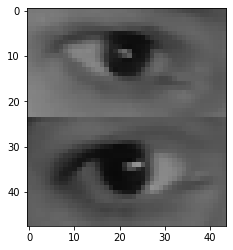

In [7]:
smp_num = 301
print(x2_load[smp_num])
print(y_load[smp_num])
plt.imshow(x1_load[smp_num].reshape((frame_h, frame_w)), cmap="gray", vmin=0, vmax=255)
plt.show()

In [11]:
print("\nNormalizing data...")
x2_chs_inp = x2_load[:, tp.CHOSEN_INPUTS]
scalers = jload(scalers_dir)
x1_scaler, x2_scaler = scalers
x1 = x1_load / x1_scaler
x2 = x2_scaler.transform(x2_chs_inp)
jdump(scalers, subject_dir + "scalers_in_blink_out.bin")


Normalizing data...


['../dataset/3/scalers_in_blink_out.bin']

In [12]:
print("\nShuffling data...")
x1_shf, x2_shf, y_shf = shuffle(x1, x2, y_load)


Shuffling data...


In [13]:
print("\nSplitting data to train and test...")
n_train = int(r_train * n_smp)
n_test = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y_train = y_shf[:n_train]
y_test = y_shf[n_train:]
print("Data shapes:")
print(x1_train.shape, x1_test.shape, x2_train.shape, x2_test.shape,
      y_train.shape, y_test.shape)


Splitting data to train and test...
Data shapes:
(765, 48, 44, 1) (135, 48, 44, 1) (765, 7) (135, 7) (765,) (135,)


In [14]:
y_train_ctg = to_categorical(y_train)
y_test_ctg = to_categorical(y_test)

x_train = [x1_train, x2_train]
x_test = [x1_test, x2_test]

In [16]:
print("\nLoading 'in_blink_out' model...")
cb = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)
model = load_model(public_model_dir)


Loading 'in_blink_out' model...


In [17]:
for layer in model.layers[:-trainable_layers]:
    layer.trainable = False
print("\nModel summary:")
print(model.summary())


Model summary:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 48, 44, 16)   416         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 24, 22, 16)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d_3[0][0]            
____________________________________________________________________________

In [19]:
print("\nRetraining the model...")
results = model.fit(x_train,
                    y_train_ctg,
                    validation_data=(x_test, y_test_ctg),
                    epochs=n_epochs,
                    callbacks=cb)
print("End of retraining...")


Retraining the model...
Epoch 1/50
24/24 [==============================] - 2s 52ms/step - loss: 0.4724 - acc: 0.9542 - val_loss: 0.3953 - val_acc: 0.9704
Epoch 2/50
24/24 [==============================] - 1s 45ms/step - loss: 0.4393 - acc: 0.9660 - val_loss: 0.4864 - val_acc: 0.9704
Epoch 3/50
24/24 [==============================] - 1s 46ms/step - loss: 0.4408 - acc: 0.9634 - val_loss: 0.3715 - val_acc: 0.9926
Epoch 4/50
24/24 [==============================] - 1s 46ms/step - loss: 0.4242 - acc: 0.9595 - val_loss: 0.3859 - val_acc: 0.9630
Epoch 5/50
24/24 [==============================] - 1s 44ms/step - loss: 0.4243 - acc: 0.9621 - val_loss: 0.3915 - val_acc: 0.9704
Epoch 6/50
24/24 [==============================] - 1s 45ms/step - loss: 0.4137 - acc: 0.9673 - val_loss: 0.3583 - val_acc: 0.9778
Epoch 7/50
24/24 [==============================] - 1s 54ms/step - loss: 0.4276 - acc: 0.9516 - val_loss: 0.3682 - val_acc: 0.9630
Epoch 8/50
24/24 [==============================] - 1s 45m

In [21]:
model.save(subject_dir + "model_in_blink_out")

INFO:tensorflow:Assets written to: ../dataset/3/model_in_blink_out\assets


In [22]:
yhat_train = model.predict(x_train).argmax(1)
yhat_test = model.predict(x_test).argmax(1)

Test
2
2


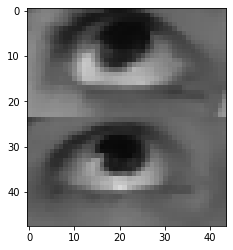

In [23]:
smp_num = 8
print("Test")
print(y_test[smp_num])
print(yhat_test[smp_num])
plt.imshow(
    (x1_test[smp_num].reshape((frame_h, frame_w)) * 255)
    .astype(np.uint8),
    cmap="gray",
    vmin=0,
    vmax=255
    )
plt.show()

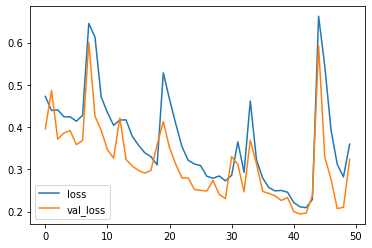

In [24]:
loss = results.history["loss"]
val_loss = results.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

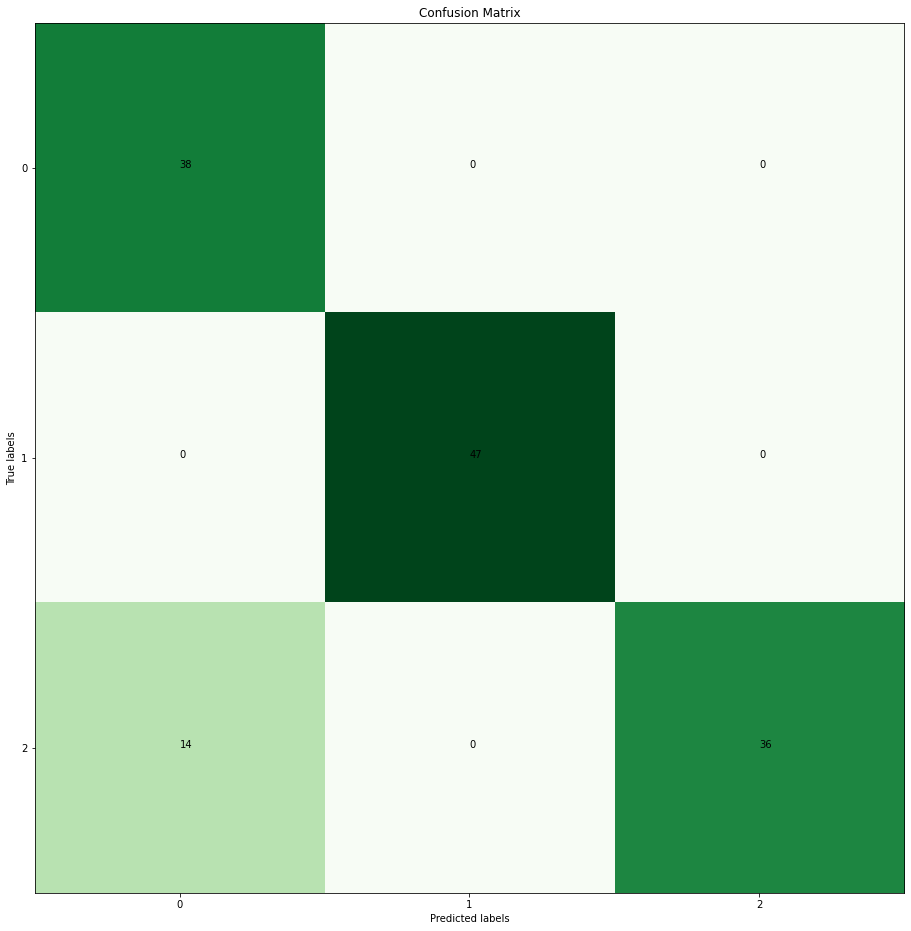

In [25]:
from sklearn.metrics import confusion_matrix

n_class = y_train_ctg.shape[1]
cm_test = confusion_matrix(y_test, yhat_test)
plt.figure(figsize=(16,16))
plt.imshow(cm_test, cmap=plt.cm.Greens)
class_arr = np.arange(n_class)
plt.xticks(class_arr)
plt.yticks(class_arr)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

for i in range(n_class):
    for j in range(n_class):
        plt.text(i, j, cm_test[j][i])